# 03 — Fusion Tuning 

**Goal**: tune fusion weights across TF-IDF, semantic, authors, numerics, and image (if eligible) using:

- **IGF-Genre@10** (primary)
- **YearFlag@10** (secondary)

**Policies here**: **no year bias**, **no caps**. Those are applied only in `04_final_recs.ipynb`.

**Notes**
- Seeds: random (seeded) + outliers (popular, pre-1900, modern, missing description, no image)
- MMR: default **on**, `λ=0.95`, `mmr_space="tfidf|authors"` (diversify lexical/author overlap)
- Genre source: **Open Library** subjects (cached); require ≥5% coverage to compute IGF-Genre@10; warn if <10%
- Save artifacts under `artifacts/recsys/hybrid_v1_rankpct/`


In [1]:
import logging, sys, os
from pathlib import Path
from sklearn.preprocessing import normalize

logging.basicConfig(level=logging.INFO)
ROOT = Path(os.getcwd()).parent
print(f"ROOT: {ROOT}")
sys.path.append(str(ROOT / "src"))
sys.path.append('..')

ROOT: c:\Users\User\Documents\book-recomendation


In [2]:
# Optional: install project requirements (uncomment if needed)
#%pip -q install -r requirements.txt
import os, sys, json, logging, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.recsys.recommend import recommend_core
from src.recsys.eval import yearflag_at_k, genre_at_k           
from src.recsys.recommend import recommend_core     

logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
log = logging.getLogger("nb03")

np.random.seed(42)
_rng = np.random.default_rng(42)


ART = Path(ROOT / "artifacts") 
ART.mkdir(parents=True, exist_ok=True)
RUN_TAG = "hybrid_v1_rankpct"
RECSYS_DIR = ART / "recsys" / RUN_TAG
RECSYS_DIR.mkdir(parents=True, exist_ok=True)
GENRE_CACHE_FP = RECSYS_DIR / "genre_cache.json"

K_EVAL = 10
N_RANDOM_SEEDS = 300
USE_MMR_DEFAULT = True
MMR_LAMBDA = 0.95
MMR_SPACE = "tfidf|authors" 

plt.rcParams["figure.figsize"] = (7.5, 5.5)

## Load data & representations (use artifacts if present)

This reuses your pipeline to load **cleaned DataFrame** and **representations** (TF-IDF, BGE-M3, authors IAF/IGF, numerics, image DINOv2).

In [3]:
from src.clean.pipeline import clean_books_dataset
from src.features_representation.pipeline import fit_or_load_all

raw = pd.read_csv(ROOT / "data/raw/book.csv")
df_clean = clean_books_dataset(raw, drop_language_col=True)

reps = fit_or_load_all(
    df_clean,
    artifacts_root=ART/"eda2",
    enable_image=True,
    run_tag_img="dinov2_vits14",
)

log.info(
    "Loaded df_clean=%s rows. Tracks: tfidf=%s semantic=%s authors=%s numerics=%s image=%s",
    len(df_clean), hasattr(reps, "X_tfidf"), hasattr(reps, "Z_sem"), hasattr(reps, "X_auth"), hasattr(reps, "X_num"), hasattr(reps, "Z_img")
)

INFO:src.clean.pipeline:Cleaning started. Input rows=4,766.
INFO:src.clean.pipeline:Trimmed whitespace in title/authors/description.
INFO:src.clean.pipeline:Built author_list from authors.
INFO:src.clean.dedupe:Deduplicated by title + shared author. Removed 1 rows (0.02%).
INFO:src.clean.dedupe:  · 'salem s lot' merged 2 rows; years=[1975, 2005]
INFO:src.clean.pipeline:Dropped language_code column.
INFO:src.clean.pipeline:Trimmed disclaimer prefix through end marker for 6 rows.
INFO:src.clean.pipeline:Flagged suspected non-English: 29 rows (median strict-stopword=0.459 | median non-ascii=0.000)
INFO:src.clean.pipeline:Description grouping added: shared groups=157 (of 4765 rows).
INFO:src.clean.pipeline:Cleaning complete. Output rows=4,765. Columns=['book_id', 'authors', 'original_publication_year', 'title', 'average_rating', 'image_url', 'description', 'author_list', 'desc_suspected_non_english', 'desc_hash', 'desc_group_size', 'desc_is_shared'].
INFO:src.features_representation.lexica

## Ensure Open Library genre cache & compute coverage

We hydrate from Open Library if needed (only **non-empty** subjects are stored). Coverage is the share of dataset books that have at least one subject in cache.

In [4]:
from src.recsys.genres import load_cache, build_igf_weights, coarse_map
from src.recsys.genres_api_openlib import hydrate_cache_openlib

cache = load_cache(GENRE_CACHE_FP)
if len(cache) < 10:
    log.info("Hydrating Open Library subjects into cache…")
    cache = hydrate_cache_openlib(df_clean, GENRE_CACHE_FP, max_updates=1500, sleep=0.1)

keys = set(cache.keys())
cov = np.mean([1 if str(int(b)) in keys else 0 for b in df_clean["book_id"].tolist()])
sha = hashlib.sha1(json.dumps(cache, sort_keys=True).encode("utf-8")).hexdigest() if cache else "empty"
log.info("Genre coverage=%.3f cache_size=%d sha1=%s", cov, len(cache), sha[:10])

sample_keys = list(keys)[:5]
for k in sample_keys:
    log.info("sample %s -> %s", k, cache[k][:5])

if cov < 0.05:
    print(f"⚠️ Coverage is {cov:.1%} (<5%). IGF-Genre@K will be skipped; use YearFlag@K only.")
elif cov < 0.10:
    print(f"⚠️ Coverage is {cov:.1%}. Results may be noisy; proceed with caution.")
else:
    print(f"✅ Coverage is {cov:.1%}. Proceeding with IGF-Genre@K.")

INFO:src.recsys.genres:load_cache ok n=600 path=c:\Users\User\Documents\book-recomendation\artifacts\recsys\hybrid_v1_rankpct\genre_cache.json


INFO:nb03:Genre coverage=0.126 cache_size=600 sha1=4dd47a76b2
INFO:nb03:sample 472343 -> ['Accident victims', 'Accident victims -- Fiction', 'Accident victims in fiction', 'Accidentes', 'Accidents']
INFO:nb03:sample 77142 -> ['--fictional works', '20th century', '442nd Regimental Combat Team', '813/.54', 'American literature']
INFO:nb03:sample 4406 -> ['American fiction (fictional works by one author)', 'American literature', 'Brothers', 'California, fiction', 'Children of prostitutes']
INFO:nb03:sample 10614 -> ['American Horror stories', 'American Novelists', 'American fiction', 'American literature', 'Authors, fiction']
INFO:nb03:sample 18693716 -> ['Automobile travel', 'Bullying in schools', 'Competitions', 'Contemporary', 'Contemporary Women']


✅ Coverage is 12.6%. Proceeding with IGF-Genre@K.


## Build IGF (inverse genre frequency) over **genre combinations**

Rare coarse-genre combinations receive higher weight.

INFO:src.recsys.genres:build_igf_weights mode=combo unique=228


,combo,count,igf
32,"fiction, other",89,0.022222
12,"fiction, mystery_thriller, other",38,0.051282
20,"fiction, other, romance",36,0.054054
72,other,27,0.071429
15,"fiction, nonfiction, other",16,0.117647
44,"biography, fiction, other",12,0.153846
61,"fiction, horror, mystery_thriller, other",12,0.153846
47,"fiction, other, war_military",11,0.166667
22,"fiction, nonfiction, other, war_military",11,0.166667
31,"children, fiction, other",10,0.181818


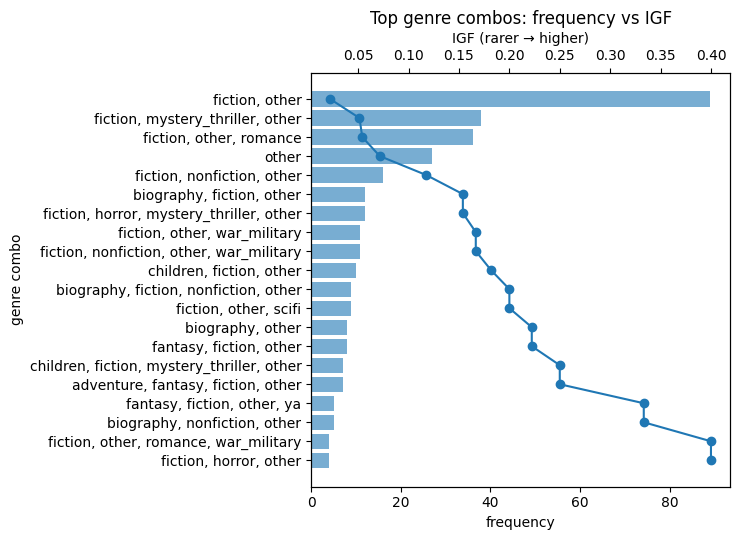

In [5]:
igf_combo = build_igf_weights(cache, mode="combo")

from collections import Counter
combo_counts = Counter()
for bid, subs in cache.items():
    coarse = tuple(sorted(list(coarse_map(subs))))
    combo_counts[coarse] += 1

igf_df = pd.DataFrame([
    {"combo": ", ".join(k), "count": v, "igf": igf_combo.get(k, 1.0)}
    for k, v in combo_counts.items()
])
igf_df = igf_df.sort_values("count", ascending=False)
display(igf_df.head(10))

if len(igf_df) > 0:
    topN = igf_df.head(20)
    fig, ax1 = plt.subplots()
    ax1.barh(topN["combo"], topN["count"], alpha=0.6)
    ax1.set_xlabel("frequency")
    ax1.set_ylabel("genre combo")
    ax2 = ax1.twiny()
    ax2.plot(topN["igf"], topN["combo"], marker="o")
    ax2.set_xlabel("IGF (rarer → higher)")
    ax1.invert_yaxis()
    plt.title("Top genre combos: frequency vs IGF")
    plt.tight_layout(); plt.show()
else:
    print("No IGF evidence to plot (empty cache).")

## Seed selection: 300 random + outliers

Adds outliers: popular, pre-1900, modern, missing description, no image.

- Deterministic: `np.random.default_rng(42)`.
- Returns **row indices**.

In [6]:
from src.recsys.utils import pick_seeds_with_outliers

seeds, random_idxs_seeds, outliers_seeds  = pick_seeds_with_outliers(
    df=df_clean,
    reps=reps,
    n_random=N_RANDOM_SEEDS,
    rng=_rng,
    include_missing_desc=True,
    include_pre1900=True,
    include_modern=True,
    include_no_image=True,
    include_popular=True,
)
print("Total seeds:", len(seeds), "Unique:", len(set(seeds)))
print("Sample seed row indices:", seeds[:10])
print("Outliers:", outliers_seeds[:4])

preview = df_clean.loc[seeds[:5], ["book_id", "title", "original_publication_year", "average_rating"]]
display(preview)

INFO:src.recsys.utils:df_num_raw good. pick_seeds_with_outliers: num_raw features loaded with 4765 rows


Total seeds: 304 Unique: 304
Sample seed row indices: [2302, 3574, 600, 2097, 420, 2829, 2545, 2607, 400, 289]
Outliers: [0, 1, 28, 753]


,book_id,title,original_publication_year,average_rating
2302,722864,"Inside the Human Body (The Magic School Bus, #3)",1989,4.26
3574,111023,Passage to Dawn (Forgotten Realms: Legacy of t...,1993,4.07
600,1067,1776,2005,4.06
2097,13833,"Emperor Mage (Immortals, #3)",1994,4.30
420,2932,Robinson Crusoe,1719,3.66


## Grid evaluation 

Primary: **IGF-Genre@10**; Secondary: **YearFlag@10**; Objective: `0.7*Genre + 0.3*YearFlag`.
We save `grid_eval_summary.csv` and pick the best weights. Image modality is auto-gated by coverage & seed image availability inside the recommender.

In [ ]:
from src.recsys.grid_search import weight_grid, evaluate_weights, fine_sweep_around

rows = []
for w in weight_grid():
    m = evaluate_weights(
        df_clean, reps, seeds=seeds, weights=w,
        genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
        lam=MMR_LAMBDA, use_mmr=USE_MMR_DEFAULT, mmr_space=MMR_SPACE
    )
    rows.append({"weights": w} | m)

grid_df = pd.DataFrame([
    {
        "tfidf": r["weights"]["tfidf"],
        "semantic": r["weights"]["semantic"],
        "authors": r["weights"]["authors"],
        "numerics": r["weights"]["numerics"],
        "image": r["weights"]["image"],
        "Genre@K": r["Genre@K"],
        "YearFlag@K": r["YearFlag@K"],
        "EvalScore": r["EvalScore"],
    } for r in rows
]).sort_values("EvalScore", ascending=False)

grid_fp = RECSYS_DIR / "grid_eval_summary.csv"
grid_df.to_csv(grid_fp, index=False)
display(grid_df.head(10))
print("Saved:", grid_fp)

best = grid_df.iloc[0]
best_w = {
    "tfidf": float(best["tfidf"]),
    "semantic": float(best["semantic"]),
    "authors": float(best["authors"]),
    "numerics": float(best["numerics"]),
    "image": float(best["image"]),
}
with open(RECSYS_DIR / "weights_selected.json", "w", encoding="utf-8") as f:
    json.dump(best_w, f, ensure_ascii=False, indent=2)
print("Selected weights:", best_w)
print("Best: EvalScore=%.4f | IGF-Genre@%d=%.4f | YearFlag@%d=%.4f" % (best["EvalScore"], K_EVAL, best["Genre@K"], K_EVAL, best["YearFlag@K"]))

def narrate(coverage, g_at_k, y_at_k):
    if coverage < 0.10:
        print(f"⚠️ Coverage {coverage:.1%} — Genre@K may be unstable; treat comparisons cautiously.")
    if g_at_k < 0.15:
        print(f"⚠️ IGF-Genre@{K_EVAL}={g_at_k:.3f} is modest. Check subject sparsity and seed mix.")
    else:
        print(f"✅ Balanced: IGF-Genre@{K_EVAL}={g_at_k:.3f}, YearFlag@{K_EVAL}={y_at_k:.3f}.")

narrate(cov, float(best["Genre@K"]), float(best["YearFlag@K"]))

INFO:src.recsys.grid_search:weight_grid size=16


INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.2, 'semantic': 0.3, 'authors': 0.1, 'numerics': 0.05} available=['tfidf', 'semantic', 'authors', 'numerics']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.3076923076923077, 'semantic': 0.4615384615384615, 'authors': 0.15384615384615385, 'numerics': 0.07692307692307693}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', 'semantic', 'authors', 'numerics'] n=4765
INFO:src.recsys.fusion:mmr_rerank_generic k=10 lam=0.950 picked=[1560, 1203, 2006, 2285, 1753, 2202, 2358, 1198, 1333, 1864]
INFO:src.recsys.fusion:renorm_weights initial={'tfidf': 0.2, 'semantic': 0.3, 'authors': 0.1, 'numerics': 0.05, 'image': 0.05} available=['tfidf', 'semantic', 'authors', 'numerics', 'image']
INFO:src.recsys.fusion:renorm_weights final={'tfidf': 0.2857142857142857, 'semantic': 0.4285714285714285, 'authors': 0.14285714285714285, 'numerics': 0.07142857142857142, 'image': 0.07142857142857142}
INFO:src.recsys.fusion:blend_ranked mods=['tfidf', '

## MMR sensitivity (λ=0.95) — on vs off

We verify MMR doesn't hurt relevance materially. Uses the **best weights** above; compares with and without MMR.

In [ ]:
m_on = evaluate_weights(
    df_clean, reps, seeds=seeds, weights=best_w,
    genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
    lam=MMR_LAMBDA, use_mmr=True, mmr_space=MMR_SPACE
)
m_off = evaluate_weights(
    df_clean, reps, seeds=seeds, weights=best_w,
    genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
    lam=MMR_LAMBDA, use_mmr=False, mmr_space=MMR_SPACE
)
comp = pd.DataFrame([
    {"setting": "MMR on", **m_on},
    {"setting": "MMR off", **m_off}
])
display(comp)

fig, ax = plt.subplots()
ax.bar(["MMR on", "MMR off"], comp["EvalScore"], alpha=0.8)
ax.set_title("EvalScore (higher is better)")
plt.show()

if comp.loc[0, "EvalScore"] + 1e-6 < comp.loc[1, "EvalScore"]:
    print("⚠️ MMR reduced EvalScore in this setting — consider turning it off for serving.")
else:
    print("✅ MMR is safe: similar or better EvalScore.")

NameError: name 'best_w' is not defined

## Ablation: drop-one-modality ΔEvalScore

We remove a modality, renormalize remaining weights, and re-evaluate. Negative Δ means that modality helps.

In [ ]:
def renorm_after_drop(w, drop_key):
    w2 = {k: (0.0 if k == drop_key else max(0.0, v)) for k, v in w.items()}
    s = sum(w2.values())
    if s == 0:
        return w2
    return {k: v/s for k, v in w2.items()}

base = evaluate_weights(
    df_clean, reps, seeds=seeds, weights=best_w,
    genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
    lam=MMR_LAMBDA, use_mmr=True, mmr_space=MMR_SPACE
)
mods = list(best_w.keys())
abl = []
for m in mods:
    w_drop = renorm_after_drop(best_w, m)
    met = evaluate_weights(
        df_clean, reps, seeds=seeds, weights=w_drop,
        genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
        lam=MMR_LAMBDA, use_mmr=True, mmr_space=MMR_SPACE
    )
    abl.append({"modality": m, "DeltaEval": met["EvalScore"] - base["EvalScore"]})
abl_df = pd.DataFrame(abl).sort_values("DeltaEval")
display(abl_df)

fig, ax = plt.subplots()
ax.barh(abl_df["modality"], abl_df["DeltaEval"], alpha=0.8)
ax.axvline(0.0, color="k", linewidth=1)
ax.set_title("Ablation ΔEvalScore (drop one)")
plt.tight_layout(); plt.show()

if (abl_df["DeltaEval"] < -1e-4).any():
    print("✅ Some modalities materially help (negative Δ when dropped).")
else:
    print("ℹ️ All modalities are marginal under current seeds; consider revisiting weights or seeds.")

NameError: name 'best_w' is not defined

## Fine sweep around best (±0.05 per weight)

Small local search to confirm stability around the chosen weights.

In [ ]:
neigh = fine_sweep_around(best_w, step=0.05)
fs_rows = []
for w in neigh:
    m = evaluate_weights(
        df_clean, reps, seeds=seeds, weights=w,
        genre_cache=cache, igf=igf_combo, k_eval=K_EVAL,
        lam=MMR_LAMBDA, use_mmr=True, mmr_space=MMR_SPACE
    )
    fs_rows.append({"weights": w} | m)

fs_df = pd.DataFrame([
    {
        "tfidf": r["weights"]["tfidf"],
        "semantic": r["weights"]["semantic"],
        "authors": r["weights"]["authors"],
        "numerics": r["weights"]["numerics"],
        "image": r["weights"]["image"],
        "Genre@K": r["Genre@K"],
        "YearFlag@K": r["YearFlag@K"],
        "EvalScore": r["EvalScore"]
    } for r in fs_rows
]).sort_values("EvalScore", ascending=False)
display(fs_df.head(10))

fs_fp = RECSYS_DIR / "fine_sweep_summary.csv"
fs_df.to_csv(fs_fp, index=False)
print("Saved:", fs_fp)

top = fs_df.iloc[0]
if float(top["EvalScore"]) > float(best["EvalScore"]) + 1e-6:
    print("✅ Fine sweep found a better point; consider adopting it.")
else:
    print("✅ Best grid point is stable; fine sweep did not significantly improve it.")

## Cluster sanity: UMAP (or PCA fallback), colored by coarse genre

We color a sample by coarse genre (from Open Library). If UMAP is unavailable, we fall back to PCA. If coverage is low, expect mixed colors.

In [ ]:
from src.eda.plots import plot_2d_embedding

Z = None
label_list = []
try:
    if getattr(reps, "Z_sem", None) is not None and isinstance(reps.Z_sem, np.ndarray) and reps.Z_sem.size:
        Z = reps.Z_sem
    elif getattr(reps, "X_num", None) is not None and isinstance(reps.X_num, np.ndarray) and reps.X_num.size:
        Z = reps.X_num
except Exception:
    Z = None

if Z is None:
    print("No embedding available for visualization.")
else:
    nvis = min(2000, Z.shape[0])
    idx_vis = _rng.choice(np.arange(Z.shape[0]), size=nvis, replace=False)
    bids = [str(int(df_clean.loc[i, "book_id"])) for i in idx_vis]
    for b in bids:
        subs = cache.get(b, [])
        coarse = ",".join(sorted(list(coarse_map(subs)))) if subs else "unknown"
        label_list.append(coarse)
    fig, ax = plot_2d_embedding(Z[idx_vis], labels=label_list, method="umap", title="2D embedding colored by coarse genre")
    plt.show()

    if cov < 0.10:
        print("⚠️ Low coverage: many 'unknown' labels; clusters may be muted.")
    else:
        print("✅ Visual clusters by genre should be visible if semantic space is good.")

# Outlier Analysis
We want to see whether our fusion model handles outlier books differently.  
Outliers here are defined via `pick_seeds_with_outliers` (e.g., norm-based).

In [ ]:
seeds, rand_idxs, outliers = pick_seeds_with_outliers(
    df=df_clean,
    reps=reps,
    n_random=20,               
    rng=np.random.default_rng(42),
    include_missing_desc=True,
    include_pre1900=True,
    include_modern=True,
    include_no_image=True,
    include_popular=True,
)

print(f"Picked {len(seeds)} seeds, {len(rand_idxs)} random, {len(outliers)} outliers.")


ModuleNotFoundError: No module named 'src'

In [ ]:
def eval_group(idxs, label, k=K_EVAL):
    scores = []
    for i in idxs:
        rec_indices, _ = recommend_core(
            df=df_clean,
            reps=reps,
            seed_idx=i,
            k=k,
            weights=best_w,
            lam=MMR_LAMBDA,
            use_mmr=USE_MMR_DEFAULT,
            mmr_space=MMR_SPACE,
            include_year_bias=False,          
            year_bias_weight=0.0,
            year_tiebreak=False,
            caps=None,                       
            image_min_coverage=0.30,
        )
        s = genre_at_k(
            seed_id=i,
            topk_ids=rec_indices,
            df=df_clean,
            genre_cache=cache,
            igf=igf_combo,
            mode="combo",
        )
        scores.append(s)
    avg = float(np.mean(scores)) if scores else float("nan")
    print(f"{label}: N={len(idxs)} | IGF-Genre@{k}={avg:.4f}")
    return avg

avg_random = eval_group(rand_idxs, "Random")
avg_outliers = eval_group(outliers, "Outliers")


## Interpretation
- If outliers show **much lower Genre@K** than random, it means fusion struggles with unusual books.  
- If performance is similar, our model is robust.  
- If outliers are higher, that may indicate they are easier to cluster (rare but possible).  

👉 We should **warn if outlier Genre@10 < 0.10**, since that suggests fusion is not generalizing well.


In [ ]:
if avg_outliers < 0.10:
    print("⚠️ Warning: Outlier performance is below 10% — fusion may be failing for rare books!")
elif avg_outliers > avg_random * 2:
    print("⚠️ Outliers perform significantly better than Random (2x) — consider adjusting weights or MMR settings.")
else:
    print("✅ Outlier performance is acceptable relative to random seeds.")


## Worst seeds by YearFlag@10 (diagnostics)

We show the five seeds with the lowest YearFlag@10 under the best weights to investigate failure cases.

In [ ]:


scores = []
for s in seeds[: min(200, len(seeds))]:
    idxs, _ = recommend_core(
        df_clean, reps, s, k=K_EVAL, weights=best_w,
        lam=MMR_LAMBDA, use_mmr=True, mmr_space=MMR_SPACE,
        include_year_bias=False, caps=None, image_min_coverage=0.3
    )
    y = yearflag_at_k(s, idxs, df_clean)
    scores.append({
        "seed_row": s,
        "book_id": int(df_clean.loc[s, "book_id"]),
        "title": df_clean.loc[s, "title"],
        "YearFlag@K": y
    })
worst = pd.DataFrame(scores).sort_values("YearFlag@K").head(5)
display(worst)
if len(worst):
    print("Investigate these seeds in 04 to see if small year bias α helps.")

## Final: persist selected weights for 04

This wrote `weights_selected.json`. In `04_final_recs.ipynb`, we will apply small year bias + caps and show cover images for the final top-5.